In [2]:
import networkx as nx
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import no_grad, cat
import torch.nn.functional as F
from torch.cuda import is_available

from torch_geometric.nn import GCNConv, SAGEConv
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, negative_sampling

from sklearn.metrics import roc_auc_score

# DGNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import GConvGRU, EvolveGCNH, GConvLSTM
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader, TwitterTennisDatasetLoader


device = 'cpu'
if is_available():
	device = 'gpu'

print(f'Using device {device}')

Using device cpu


## Node Classification

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset

Cora()

In [5]:
graph = dataset[0]
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [5]:
graph.edge_index.T

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

Cora dataset classes:

0. Theory
1. RL
2. Genetic Algorithms
3. NN
4. Probabilistic Methods
5. Case Based
6. Rule Learning

In [6]:
print('Class distribution')
sorted(Counter(graph.y.tolist()).items())

Class distribution


[(0, 351), (1, 217), (2, 418), (3, 818), (4, 426), (5, 298), (6, 180)]

Graph Visualization

In [7]:
def convert_to_networkx(graph):
	g = to_networkx(graph, node_attrs=['x'])
	y = graph.y.numpy()
	return g, y

def plot_graph(g, y):
	plt.figure(figsize=(9,7))
	nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
	plt.show()


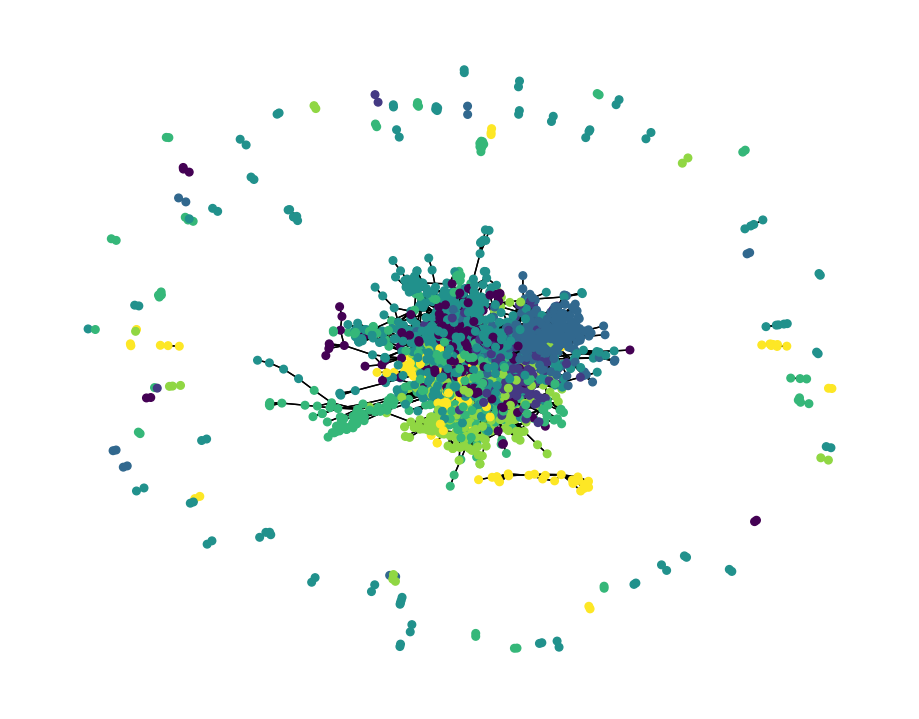

In [8]:
g, y = convert_to_networkx(graph)
plot_graph(g, y)

In [6]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### Baseline -- MLP

In [10]:
class MLP(nn.Module):
	def __init__(self, dataset):
		super().__init__()
		self.dataset = dataset

		self.layers = nn.Sequential(
			nn.Linear(dataset.num_node_features, 64),
			nn.ReLU(),
			nn.Linear(64, 32),
			nn.ReLU(),
			nn.Linear(32, dataset.num_classes)
		)
	
	def forward(self, data):
		x = data.x # Only using node features
		output = self.layers(x)
		return output

In [7]:
def eval_node_classifier(model, graph, mask):
	model.eval()

	pred		= model(graph).argmax(dim=1)
	correct	= (pred[mask] == graph.y[mask]).sum()
	acc 		= correct/mask.sum()
		
	return acc

def train_node_classifier(model, graph, optimizer, criterion, n_epochs = 200):

	train_lss_curve = []

	for epoch in range(1, n_epochs+1):
		model.train()
		optimizer.zero_grad()

		out 	= model(graph)
		loss	= criterion(out[graph.train_mask], graph.y[graph.train_mask])

		train_lss_curve.append(loss.item())
		
		loss.backward()
		optimizer.step()

		acc		= eval_node_classifier(model, graph, graph.val_mask)

		if epoch%2 == 0:
			print(f'Epoch {epoch}, Train loss {loss:.3f} Val acc {acc:.3f}')

	return model, train_lss_curve

lr = 0.01
wd = 5e-4
n_epochs = 20

mlp 					= MLP(dataset).to(device)
optimizer_mpl = Adam(mlp.parameters(), lr=lr, weight_decay=wd)
criterion 		= nn.CrossEntropyLoss()

mlp, train_lss_curve = train_node_classifier(mlp, graph, optimizer_mpl, criterion, n_epochs)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test accuracy {test_acc:.2f}%')


NameError: name 'MLP' is not defined

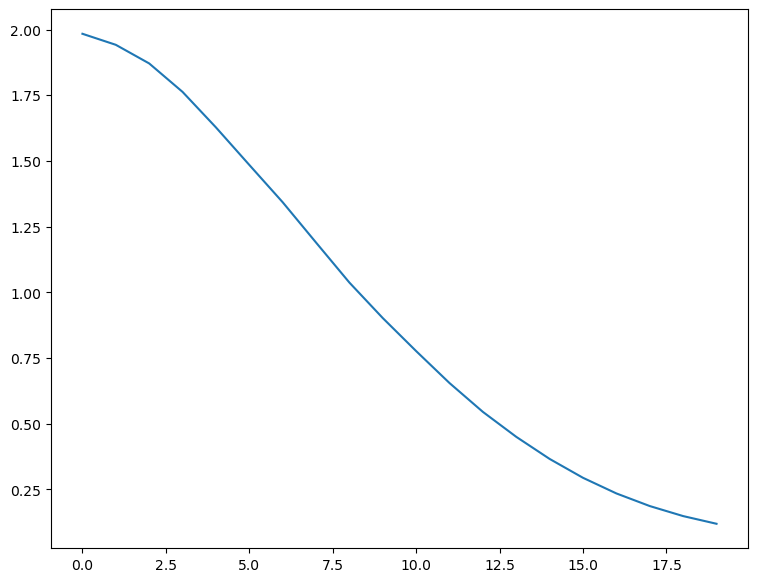

In [14]:
plt.figure(figsize=(9,7))
plt.plot(range(n_epochs), train_lss_curve)

### GCN

In [8]:
class GCN(nn.Module):
	def __init__(self, dataset):
		super().__init__()
		self.dataset = dataset

		self.conv1 = SAGEConv(dataset.num_node_features, 16)
		self.conv2 = SAGEConv(16, dataset.num_classes)
	
	def forward(self, data):
		x, edge_index = data.x, data.edge_index

		x = self.conv1(x, edge_index)
		x = F.relu(x)
		x = self.conv2(x, edge_index)

		return x
	
gcn = GCN(dataset).to(device)
optimizer_gcn = Adam(gcn.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
gcn, train_lss_curve = train_node_classifier(gcn, graph, optimizer_gcn, criterion, n_epochs)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test accuracy {test_acc:.2f}%')

Epoch 2, Train loss 1.780 Val acc 0.336
Epoch 4, Train loss 1.412 Val acc 0.513
Epoch 6, Train loss 1.058 Val acc 0.786
Epoch 8, Train loss 0.779 Val acc 0.841
Epoch 10, Train loss 0.561 Val acc 0.863
Epoch 12, Train loss 0.412 Val acc 0.875
Epoch 14, Train loss 0.309 Val acc 0.908
Epoch 16, Train loss 0.240 Val acc 0.915
Epoch 18, Train loss 0.193 Val acc 0.915
Epoch 20, Train loss 0.156 Val acc 0.911
Test accuracy 0.88%


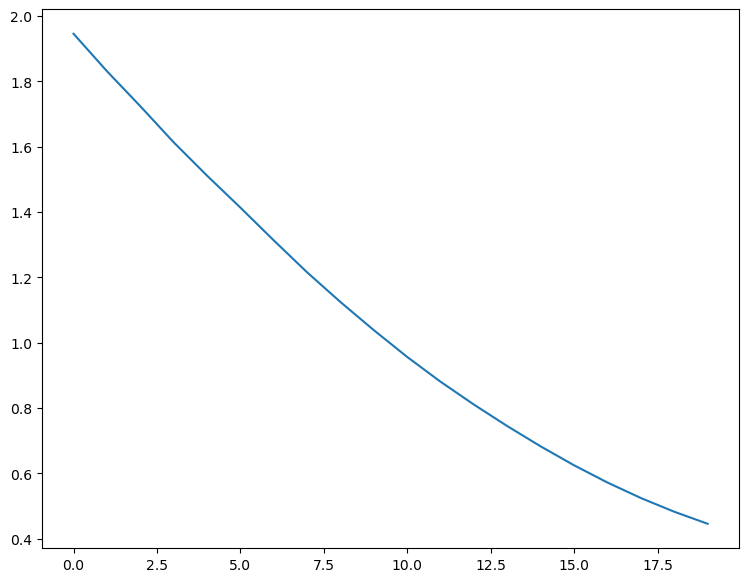

In [17]:
plt.figure(figsize=(9,7))
plt.plot(range(n_epochs), train_lss_curve)

In [18]:
mlp_total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
gcn_total_params = sum(p.numel() for p in gcn.parameters() if p.requires_grad)

print(f'MLP total parameters {mlp_total_params}, GCN total parameters {gcn_total_params}')

MLP total parameters 94087, GCN total parameters 23063


## Link Prediction

In [19]:
class Net(nn.Module):
	def __init__(self, in_channels, hidden_channels, out_channels):
		super().__init__()
		self.conv1 = GCNConv(in_channels, hidden_channels)
		self.conv2 = GCNConv(hidden_channels, out_channels)

	def encode(self, x, edge_index):
		x = self.conv1(x, edge_index).relu()
		x = self.conv2(x,edge_index)
		return x

	def decode(self, z, edge_label_index):
		return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)  # product of a pair of nodes on each edge

	def decode_all(self, z):
		prob_adj = z @ z.t()
		return (prob_adj > 0).nonzero(as_tuple=False).t()

In [21]:
def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=100):
	# Initialize lists to track the loss on training data and AUC on validation data
	train_lss_curve = []
	val_auc_curve		= []

	for epoch in range(1, n_epochs + 1):
		model.train()
		optimizer.zero_grad()

		# Compute node embeddings using the encode function of the model
		z = model.encode(train_data.x, train_data.edge_index)

		# Dynamically sample negative edges (edges that are not present in the graph)
		neg_edge_index = negative_sampling(
				edge_index = train_data.edge_index,
				num_nodes = train_data.num_nodes,
				num_neg_samples = train_data.edge_label_index.size(1),
				method='sparse'
			)
		
		# Combine real and negative edges
		edge_label_index = cat(
				[train_data.edge_label_index, neg_edge_index],
				dim=-1,
			)
		# Create labels for real edges (1) and negative edges (0)
		edge_label = cat(
			[
				train_data.edge_label,
				train_data.edge_label.new_zeros(neg_edge_index.size(1))
			],
			dim=0
		)

		# Decode the embeddings to predict the presence of edges
		out	= model.decode(z, edge_label_index).view(-1)

		loss = criterion(out, edge_label)
		train_lss_curve.append(loss.item())

		loss.backward()
		optimizer.step()

		val_auc = eval_link_predictor(model, val_data)
		val_auc_curve.append(val_auc.item())

		if epoch % 10 == 0:
			print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

	return model, train_lss_curve, val_auc_curve


@no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z 	= model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [22]:
split = T.RandomLinkSplit(
	num_val=0.1,
	num_test=0.1,
	is_undirected=True,
	add_negative_train_samples=False,
	neg_sampling_ratio=1.0
)

train_data, val_data, test_data = split(graph)

In [18]:
print(train_data)
print(val_data)
print(test_data)

Data(x=[2708, 1433], edge_index=[2, 8448], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[4224], edge_label_index=[2, 4224])
Data(x=[2708, 1433], edge_index=[2, 8448], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])


In [19]:
test_data.edge_label

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [20]:
test_data.edge_label_index.T

tensor([[1185, 2590],
        [1050, 2564],
        [2065, 2067],
        ...,
        [1087, 1531],
        [2599,  480],
        [1235,  242]])

In [23]:
n_epochs = 100

model = Net(dataset.num_features, 128, 64).to(device)

optimizer = Adam(params=model.parameters(), lr=lr, weight_decay=wd)
criterion = nn.BCEWithLogitsLoss()

model, train_lss_curve, val_auc_curve = train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs)

test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.2f}%")

Epoch: 010, Train Loss: 0.655, Val AUC: 0.789
Epoch: 020, Train Loss: 0.551, Val AUC: 0.848
Epoch: 030, Train Loss: 0.473, Val AUC: 0.906
Epoch: 040, Train Loss: 0.458, Val AUC: 0.913
Epoch: 050, Train Loss: 0.440, Val AUC: 0.923
Epoch: 060, Train Loss: 0.435, Val AUC: 0.928
Epoch: 070, Train Loss: 0.425, Val AUC: 0.928
Epoch: 080, Train Loss: 0.425, Val AUC: 0.926
Epoch: 090, Train Loss: 0.425, Val AUC: 0.928
Epoch: 100, Train Loss: 0.425, Val AUC: 0.933
Test: 0.92%


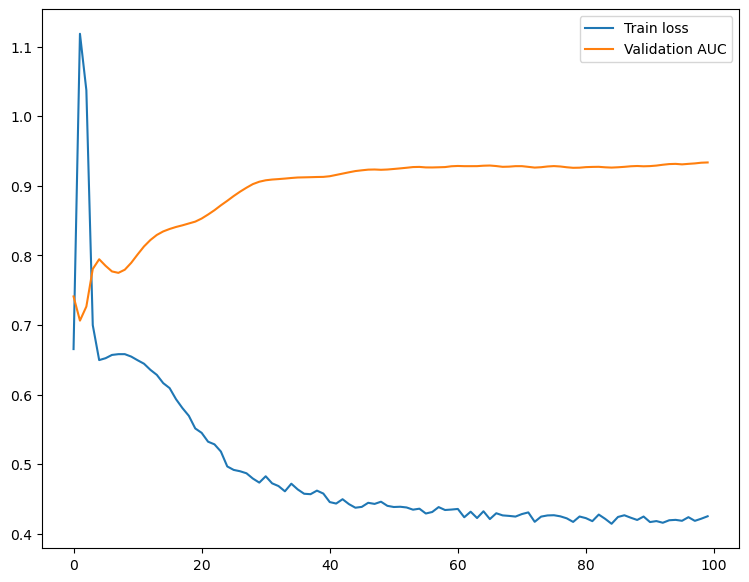

In [24]:
plt.figure(figsize=(9,7))
plt.plot(range(n_epochs), train_lss_curve, label='Train loss')
plt.plot(range(n_epochs), val_auc_curve, label='Validation AUC')
plt.legend()

## DGNN - Static Graph, Dynamic Signal

In [2]:
wiki_loader = WikiMathsDatasetLoader()

wiki_dataset = wiki_loader.get_dataset(lags=14)

wiki_train_dataset, wiki_test_dataset = temporal_signal_split(wiki_dataset, train_ratio=0.5)

In [26]:
wiki_dataset

In [27]:
wiki_dataset.snapshot_count

717

Timestep: 0


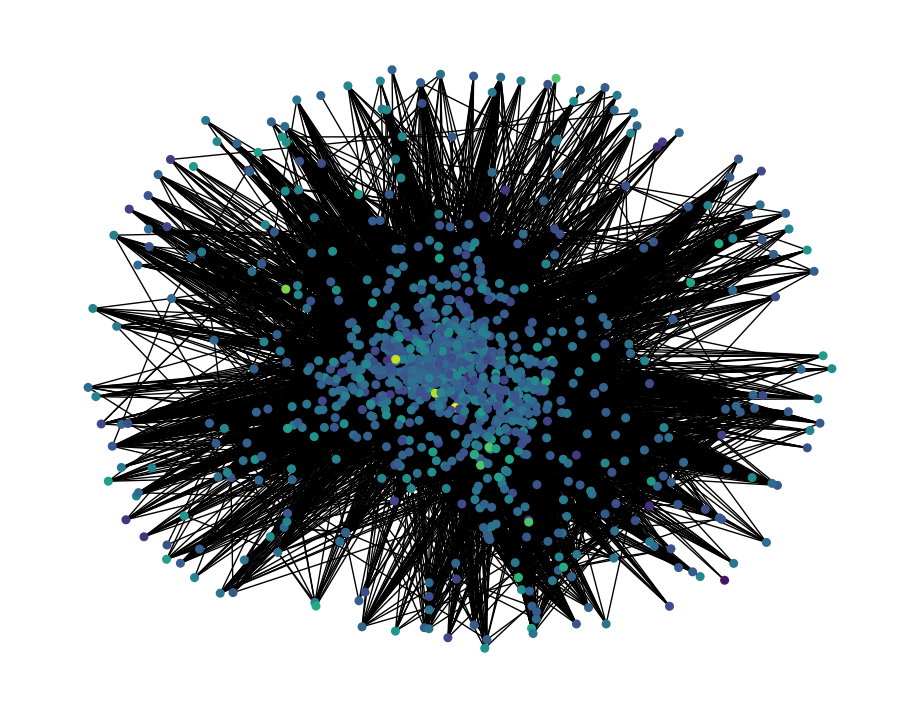

Timestep: 100


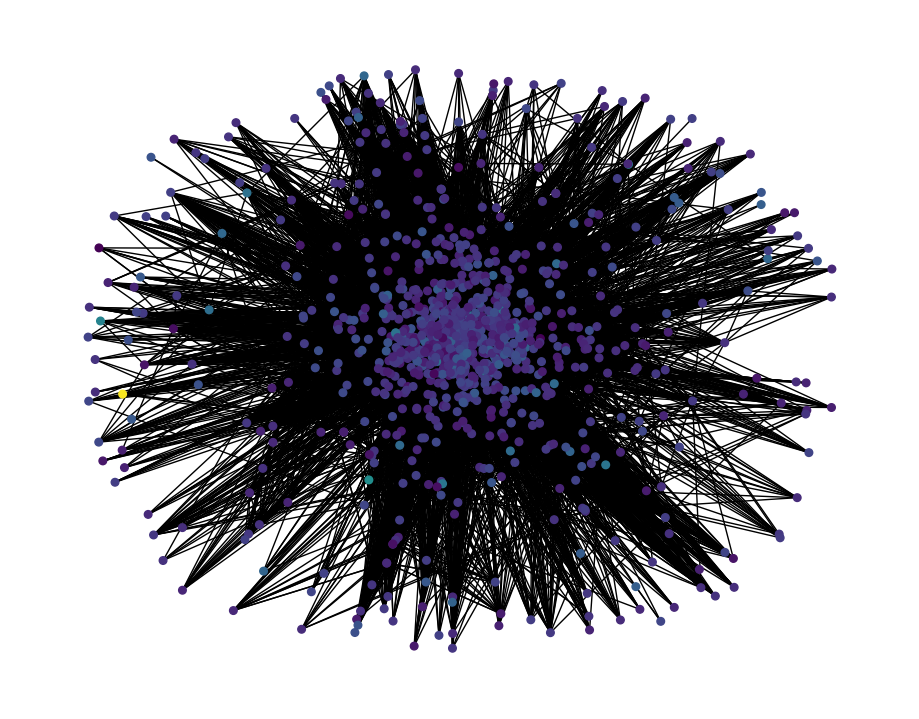

Timestep: 200


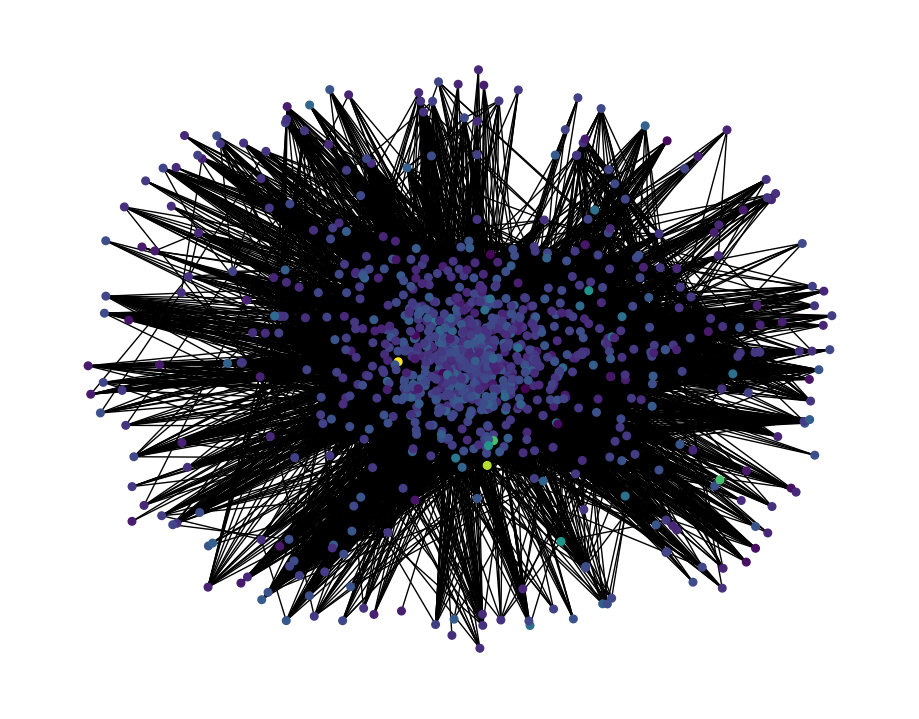

Timestep: 300


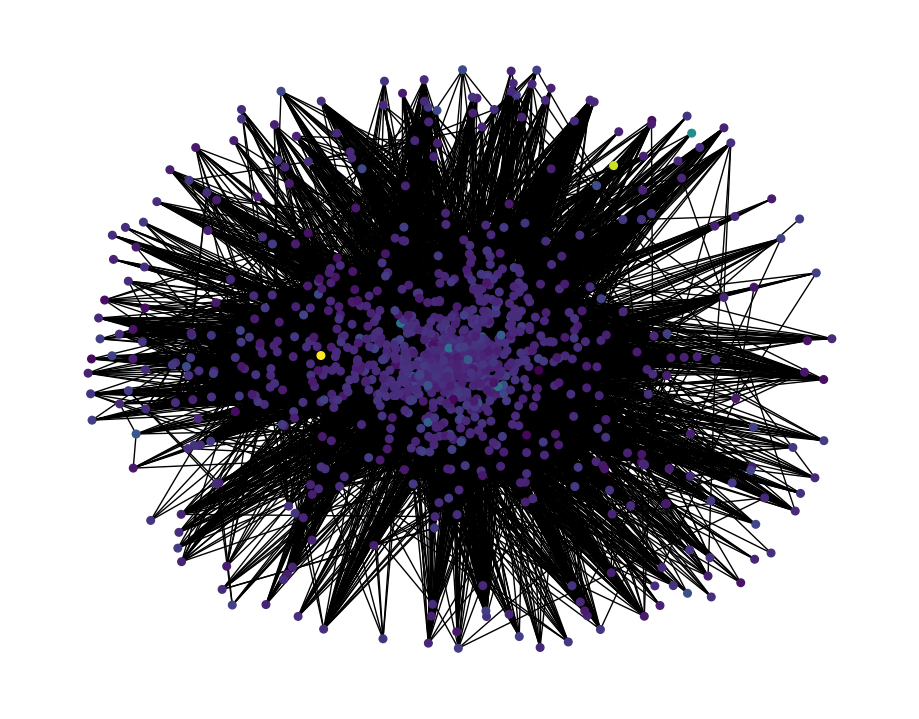

Timestep: 400


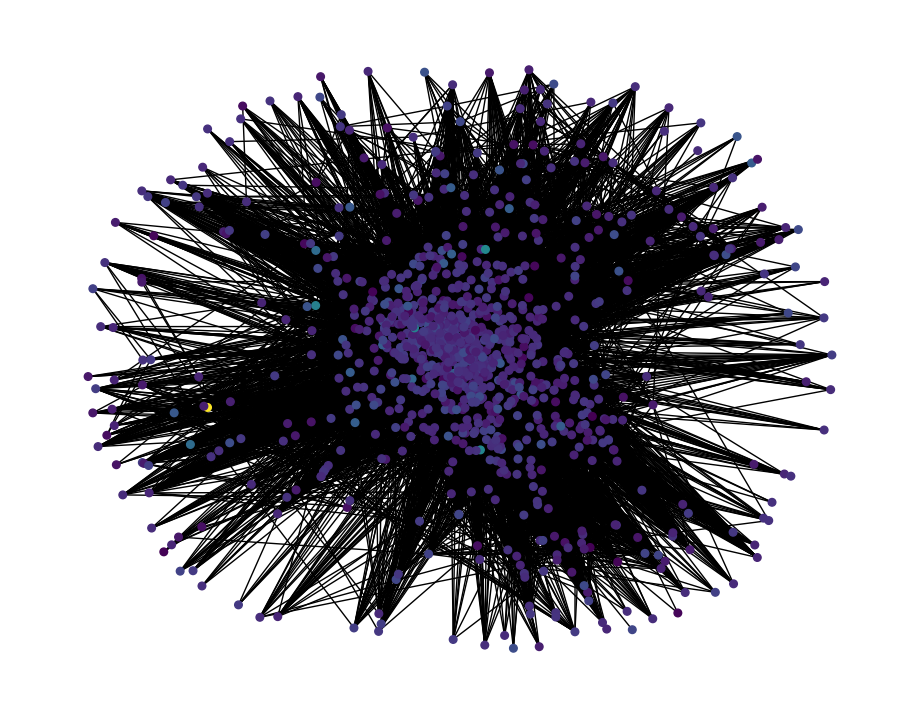

Timestep: 500


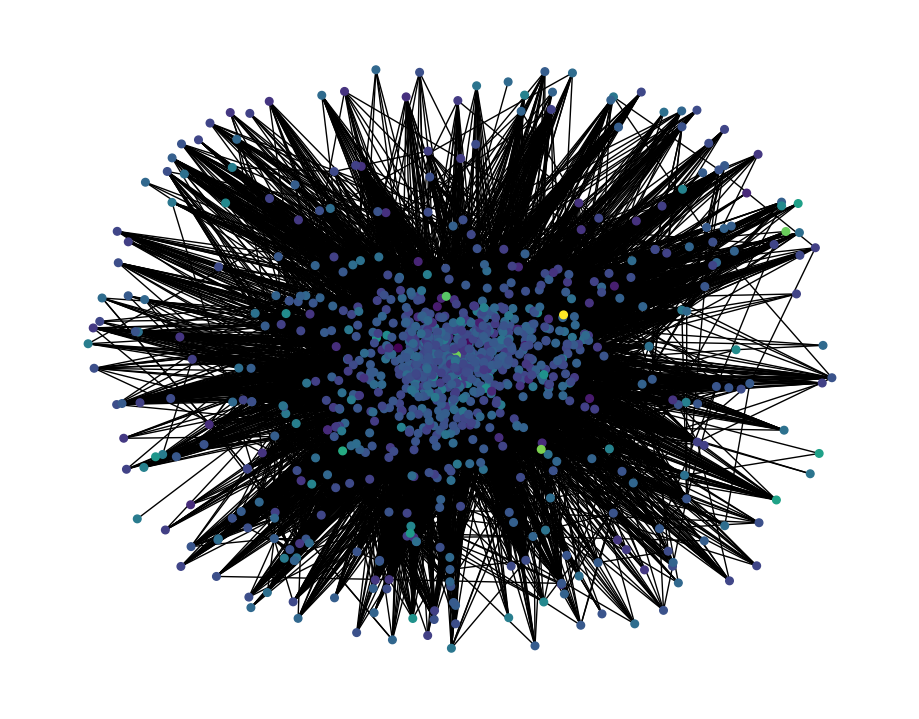

Timestep: 600


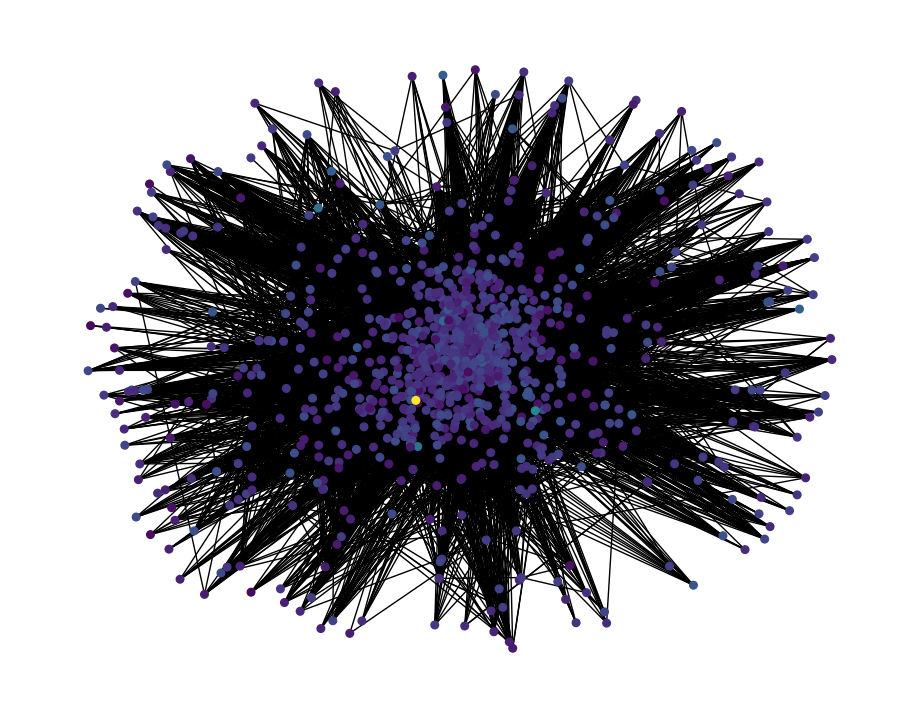

Timestep: 700


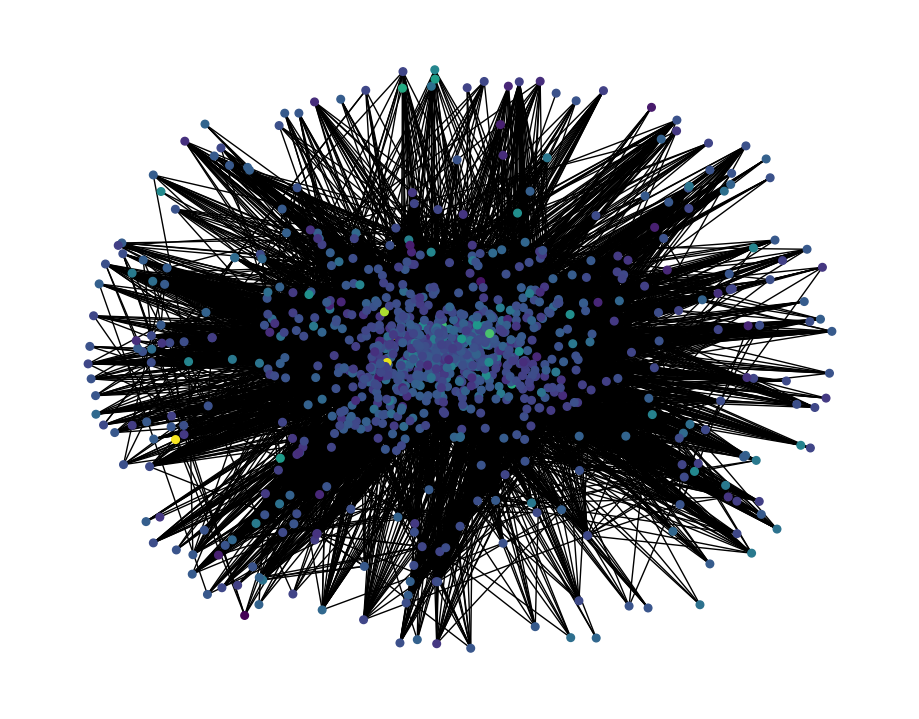

In [28]:
for time, snapshot in enumerate(wiki_dataset):
	if time % 100 == 0:
		print(f'Timestep: {time}')
		g, y = convert_to_networkx(snapshot)
		plot_graph(g, y)

In [3]:
class DGCN_GRU(nn.Module):
	def __init__(self, node_features, filters):
		super(DGCN_GRU, self).__init__()
		self.recurrent = GConvGRU(node_features, filters, 2)
		self.linear = nn.Linear(filters, 1)

	def forward(self, x, edge_index, edge_weight):
		h = self.recurrent(x, edge_index, edge_weight)
		h = F.relu(h)
		h = self.linear(h)
		return h

class DGCN_LSTM(nn.Module):
	def __init__(self, node_features, filters):
		super(DGCN_LSTM, self).__init__()
		self.recurrent = GConvLSTM(node_features, filters, 2)
		self.linear = nn.Linear(filters, 1)

	def forward(self, x, edge_index, edge_weight):
		h, _ = self.recurrent(x, edge_index, edge_weight)
		h = F.relu(h)
		h = self.linear(h)
		return h
	
class EvolveGCN(nn.Module):
	def __init__(self, number_of_nodes, node_features, filters):
		super(EvolveGCN, self).__init__()
		self.recurrent = EvolveGCNH(number_of_nodes, node_features)
		self.linear = nn.Linear(filters, 1)

	def forward(self, x, edge_index, edge_weight):
		h = self.recurrent(x, edge_index, edge_weight)
		h = F.relu(h)
		h = self.linear(h)
		return h

In [4]:
models = {
	'DGNN - GRU': DGCN_GRU(node_features=14, filters=32),
	'DGNN - LSTM': DGCN_LSTM(node_features=14, filters=32),
	'EvolveGCN' : EvolveGCN(number_of_nodes=1068, node_features=14, filters=14)
}

epochs = 10

for model_name in models:
	print(f'::: Training {model_name} :::')
	model			= models[model_name]
	optimizer = Adam(model.parameters(), lr=0.01)
	
	model.train()

	for epoch in tqdm(range(epochs)):
		for time, snapshot in enumerate(wiki_train_dataset):
			y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
			cost = torch.mean((y_hat-snapshot.y)**2)
			cost.backward()
			optimizer.step()
			optimizer.zero_grad()

	print(f'::: Evaluating {model_name} :::')
	model.eval()
	cost = 0

	for time, snapshot in enumerate(wiki_test_dataset):
		y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
		cost = cost + torch.mean((y_hat-snapshot.y)**2)

	cost = cost / (time+1)
	cost = cost.item()
	print(f'|\n*--> MSE: {cost:.4f}\n')

::: Training DGNN - GRU :::


  0%|          | 0/10 [00:00<?, ?it/s]

::: Evaluating DGNN - GRU :::
|
*--> MSE: 0.8026

::: Training DGNN - LSTM :::


  0%|          | 0/10 [00:00<?, ?it/s]

::: Evaluating DGNN - LSTM :::
|
*--> MSE: 0.7867

::: Training EvolveGCN :::


  0%|          | 0/10 [00:00<?, ?it/s]

::: Evaluating EvolveGCN :::
|
*--> MSE: 0.7540



## DGNN - Dynamic Graph, Dynamic Signal

In [37]:
twitter_loader = TwitterTennisDatasetLoader(event_id='rg17')

twitter_dataset = twitter_loader.get_dataset()

twitter_train_dataset, twitter_test_dataset = temporal_signal_split(twitter_dataset, train_ratio=0.5)

In [38]:
twitter_dataset

In [39]:
twitter_dataset.snapshot_count

120

Timestep: 0


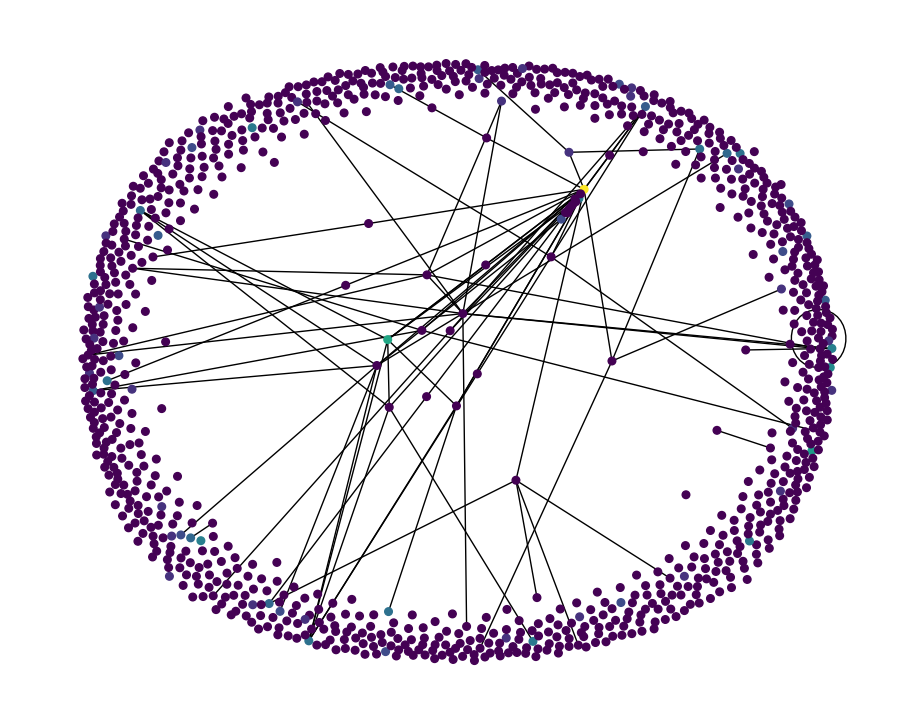

Timestep: 40


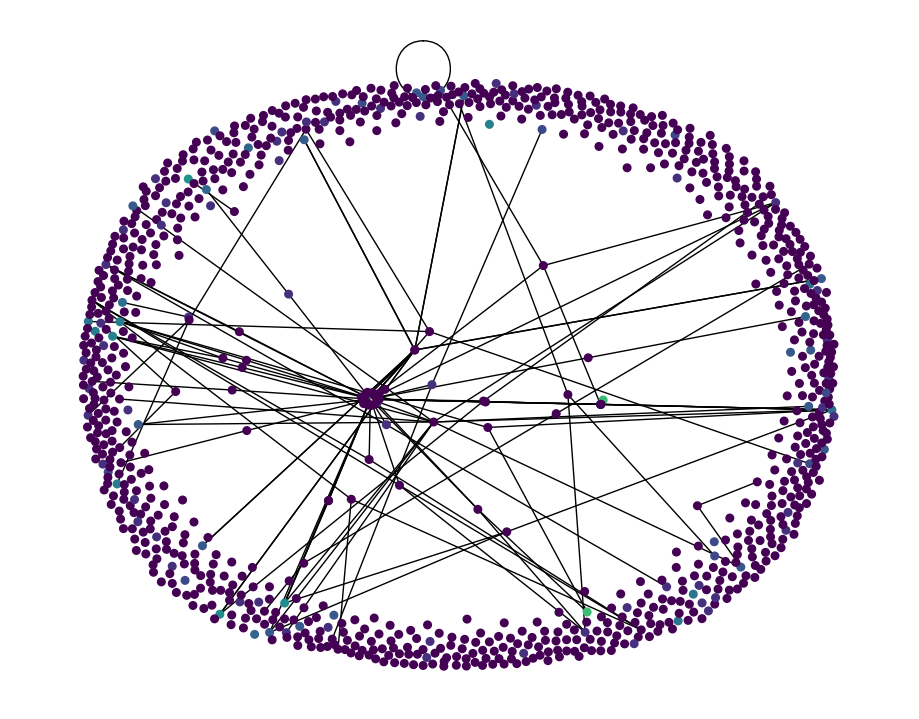

Timestep: 80


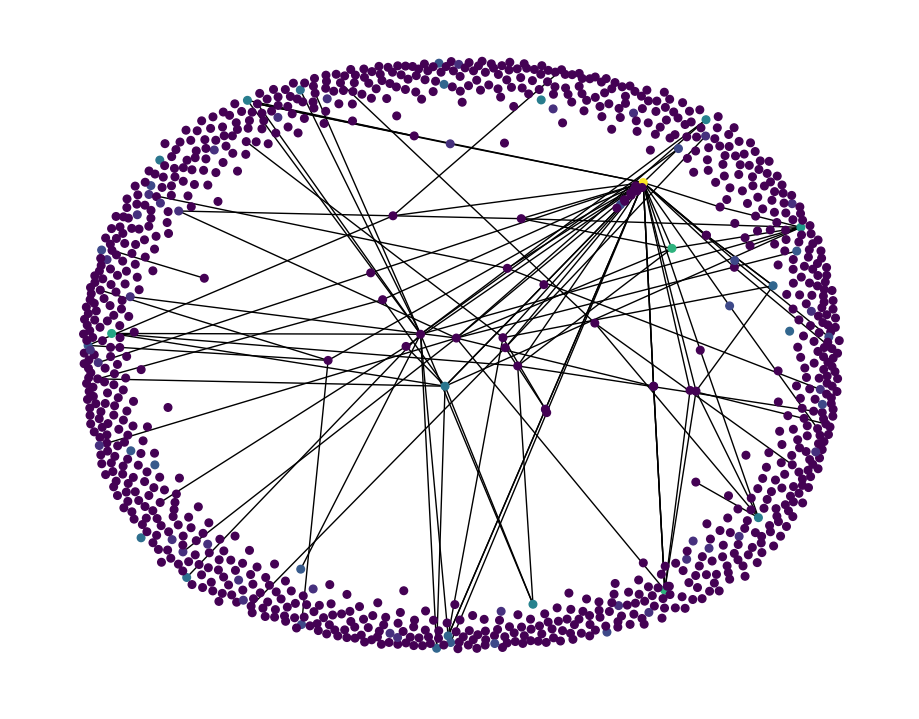

In [40]:
for time, snapshot in enumerate(twitter_dataset):
	if time % 40 == 0:
		print(f'Timestep: {time}')
		g, y = convert_to_networkx(snapshot)
		plot_graph(g, y)

In [ ]:
epochs = 1

for model_name in models:
	print(f'::: Training {model_name} :::')
	model			= models[model_name]
	optimizer = Adam(model.parameters(), lr=0.01)
	
	model.train()

	for epoch in tqdm(range(epochs)):
		for time, snapshot in enumerate(wiki_train_dataset):
			y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
			cost = torch.mean((y_hat-snapshot.y)**2)
			cost.backward()
			optimizer.step()
			optimizer.zero_grad()

	print(f'::: Evaluating {model_name} :::')
	model.eval()
	cost = 0

	for time, snapshot in enumerate(wiki_test_dataset):
		y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
		cost = cost + torch.mean((y_hat-snapshot.y)**2)

	cost = cost / (time+1)
	cost = cost.item()
	print(f'|\n*--> MSE: {cost:.4f}\n')

In [48]:
models = {
	'DGNN - GRU': DGCN_GRU(node_features=16, filters=32),
	'DGNN - LSTM': DGCN_LSTM(node_features=16, filters=32),
}

epochs = 10

for model_name in models:
	print(f'::: Training {model_name} :::')
	model			= models[model_name]
	optimizer = Adam(model.parameters(), lr=0.01)

	model.train()

	for epoch in tqdm(range(epochs)):
		for time, snapshot in enumerate(twitter_train_dataset):
			y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
			cost = torch.mean((y_hat-snapshot.y)**2)
			cost.backward()
			optimizer.step()
			optimizer.zero_grad()
	
	print(f'::: Evaluating {model_name} :::')
	model.eval()
	cost = 0

	for time, snapshot in enumerate(twitter_test_dataset):
		y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
		cost = cost + torch.mean((y_hat-snapshot.y)**2)

	cost = cost / (time+1)
	cost = cost.item()
	print(f'|\n*--> MSE: {cost:.4f}\n')

::: Training DGNN - GRU :::


  0%|          | 0/10 [00:00<?, ?it/s]

::: Evaluating DGNN - GRU :::
|
*--> MSE: 0.4261

::: Training DGNN - LSTM :::


  0%|          | 0/10 [00:00<?, ?it/s]

::: Evaluating DGNN - LSTM :::
|
*--> MSE: 0.4261

